In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install optuna
!pip install shap

In [14]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Colab Notebooks Stroke Prediction/healthcare-dataset-stroke-data.csv")
df.columns = [col.lower() for col in df.columns]

columns = ["id",                # Unikalnu identyfikator pacjenta
           "gender",            # Płeć pacjenta
           "age",               # Wiek pacjenta
           "hypertension",      # Czy pacjent posiada nadciśnienie
           "heart_disease",     # Czy pacjent posiada jakąkolwiek chorobę serca
           "ever_married",      # Czy pacjent był żonaty
           "work_type",         # Rodzaj wykonywanej pracy
           "residence_type",    # Obszar zamieszkania - wiejski lub miejski
           "avg_glucose_level", # Średni poziom glukozy we krwi
           "bmi",               # Wskaźnik masy ciała
           "smoking_status",    # Wcześniej palił/nigdy nie palił/pali/nieznany
           "stroke"]            # 1 jeśli pacjent miał udar, 0 jesli nie

In [15]:
df[df["age"] < 18].count()["id"]

856

In [16]:
df[df["age"] < 18].head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
282,33759,Female,3.00,0,0,No,children,Urban,73.74,16.0,Unknown,0
284,26325,Male,14.00,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
288,70970,Female,17.00,0,0,No,Self-employed,Urban,82.18,23.4,Unknown,0
290,55680,Male,13.00,0,0,No,children,Urban,114.84,18.3,Unknown,0
291,11014,Male,4.00,0,0,No,children,Rural,79.17,20.0,Unknown,0


In [17]:
condition = ((df["age"] < 18) & 
             (df["work_type"] != "children"))
df[condition].head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
288,70970,Female,17.0,0,0,No,Self-employed,Urban,82.18,23.4,Unknown,0
395,23462,Female,17.0,0,0,No,Private,Urban,87.52,39.2,never smoked,0
410,54975,Male,7.0,0,0,No,Self-employed,Rural,64.06,18.9,Unknown,0
455,7351,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
538,43134,Female,16.0,0,0,No,Private,Rural,155.43,27.3,never smoked,0
672,31145,Female,17.0,0,0,No,Private,Urban,67.81,55.7,never smoked,0
681,54182,Female,16.0,0,0,No,Private,Rural,74.98,21.4,never smoked,0


* Pomiar BMI nie dotyczy osób niepełnoletnich
* Osoba niepełnoletnia nie może zawrzeć związku małżeńskiego
* Osoby niepełnoletnie zazwyczaj nie pracują
* Palenie, Nadciśnienie czy Choroby serca osób niepełnoletnich (w większości) nie dotyczą


Obserwacje, w których 8 czy 7 latek prowadzą działaność gospodarczą (oraz inne nietypowe) wymagałyby konsultacji ze specjalistą. Prawdopodobne błędy w kolekcjonowaniu danych.


In [18]:
df = df[df["age"] > 18]

In [19]:
categorical_columns = ["gender",
                       "hypertension",
                       "heart_disease",
                       "ever_married",
                       "work_type",
                       "residence_type",
                       "smoking_status"]

numerical_columns = ["age",
                     "avg_glucose_level",
                     "bmi"]

target = "stroke"

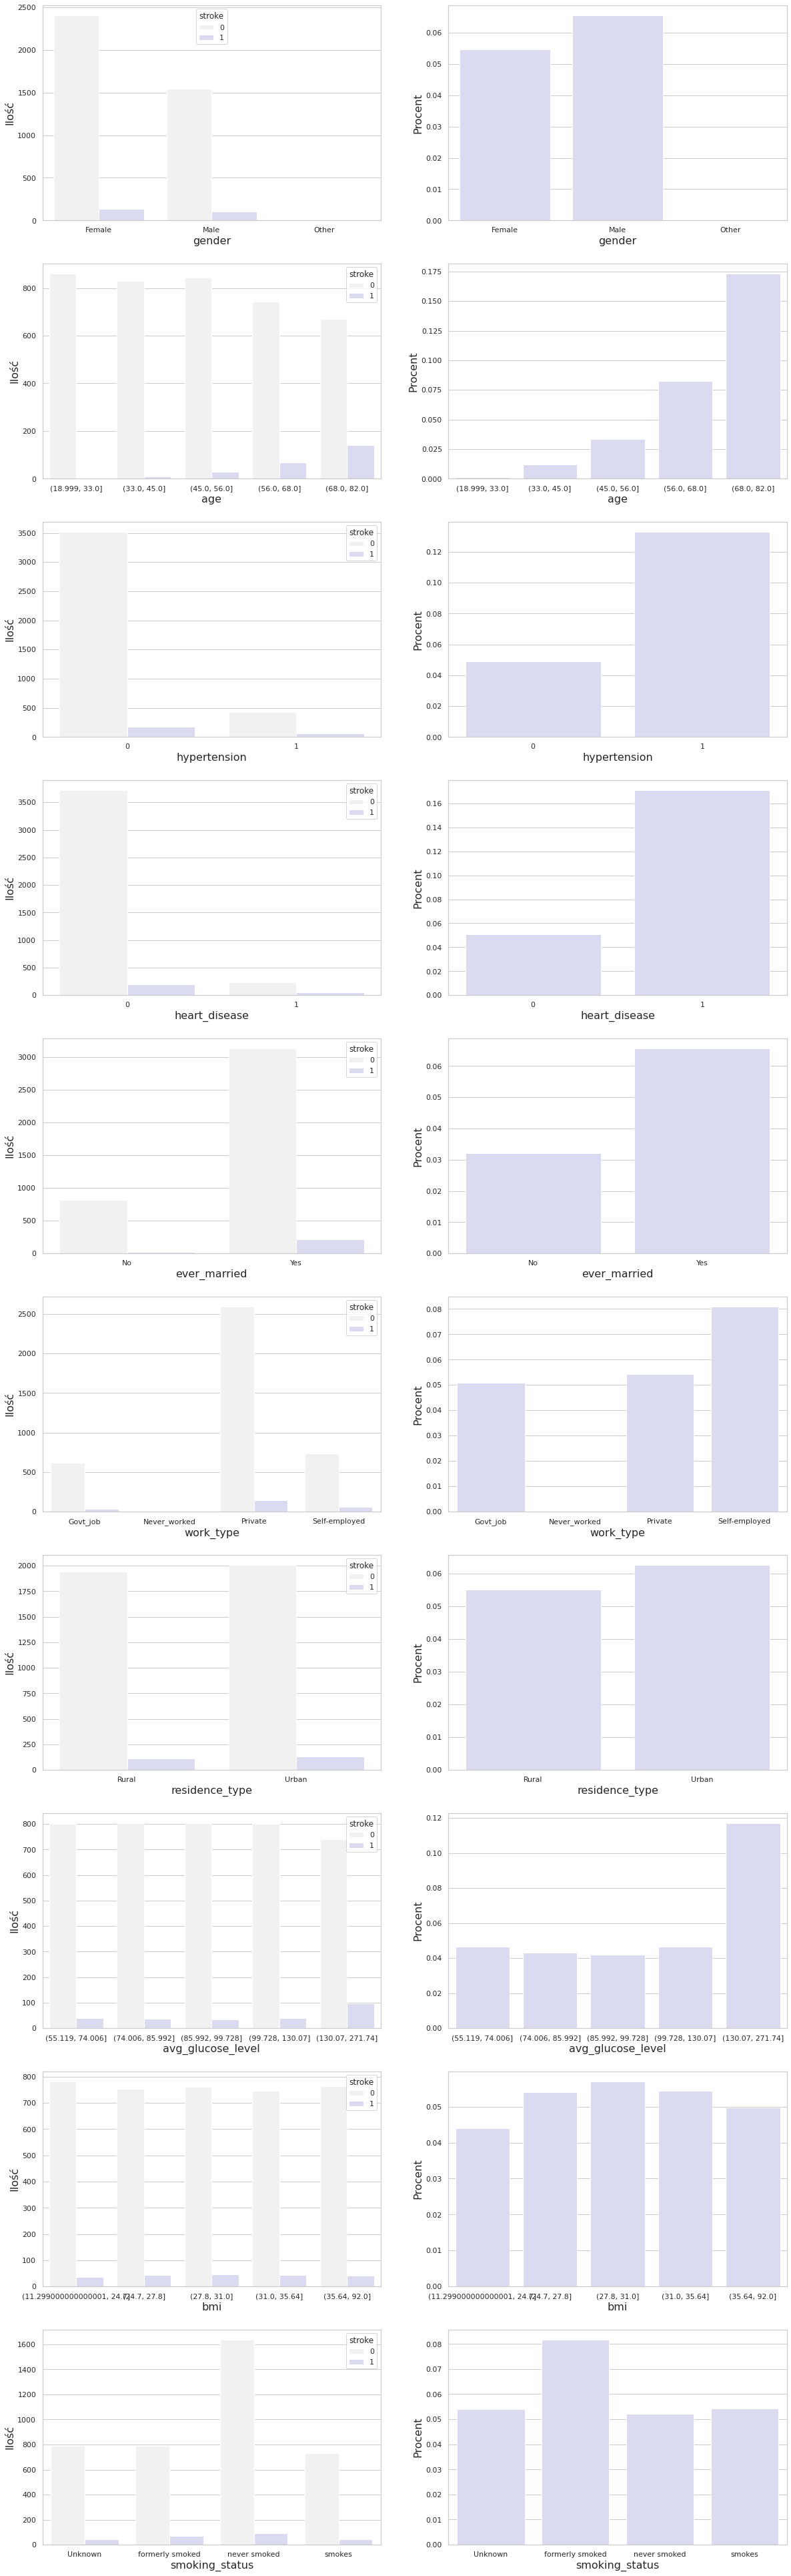

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")

columns = ["gender",
           "age",
           "hypertension",
           "heart_disease",
           "ever_married",
           "work_type",
           "residence_type",
           "avg_glucose_level",
           "bmi",
           "smoking_status"]


def plot_cnt_prc(feature, target, data, axes):
  sns.barplot(x = feature,
              y = "id",
              data = data.groupby([feature, target]).count().reset_index(),
              color = "#d6d6f5",
              hue = target,
              ax = axes[0])
  axes[0].set_xlabel(axes[0].get_xlabel(), size = 16)
  axes[0].set_ylabel("Ilość", size = 16)
  sns.barplot(x = feature,
              y = target,
              data = data.groupby(feature).mean().reset_index(),
              color = "#d6d6f5",
              ax = axes[1])
  axes[1].set_xlabel(axes[1].get_xlabel(), size = 16)
  axes[1].set_ylabel("Procent", size = 16)


fig, axes = plt.subplots(10, 2, figsize = (20, 70))
data = df.copy()
for ax, col in zip(axes, columns):
  if col in numerical_columns:
    data[col] = pd.qcut(data[col],
                        q = 5,
                        duplicates = "drop")
  plot_cnt_prc(col, target, data, ax)

plt.show()

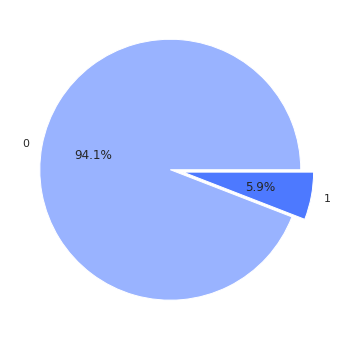

In [21]:
counts = df[target].value_counts()
plt.figure(figsize = (12, 6))

plt.pie(x = counts,
        labels = counts.keys(),
        autopct = "%.1f%%",
        explode = (0, 0.1),
        colors = ["#99b3ff", "#4d79ff"])
plt.show()

In [22]:
def correlation_plot(df, 
                     columns, 
                     method = "pearson", 
                     figsize = (12, 6)):
    corr = df.loc[:, columns].corr(method = method)
    mask = np.triu(np.ones_like(corr, dtype = np.bool))
    
    plt.figure(figsize = figsize)
    heatmap = sns.heatmap(data = corr,
                          mask = mask,
                          vmin = -1,
                          vmax = 1,
                          annot = True,
                          cmap = "coolwarm")
    heatmap.set_title("Correlation Heatmap", fontdict = {"fontsize": 15})
    plt.show()
  
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

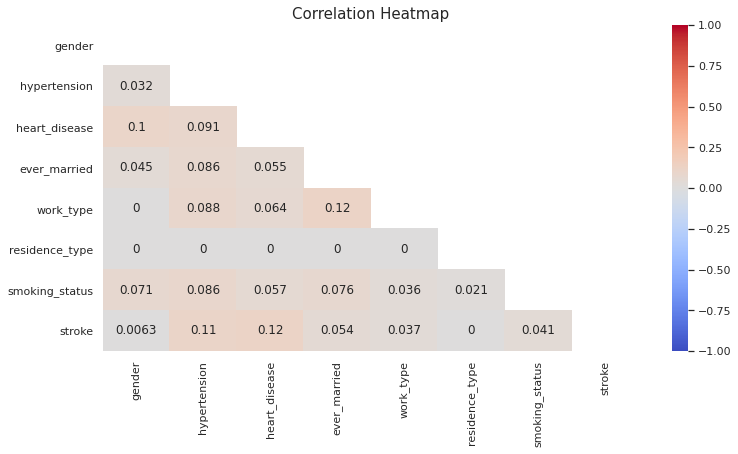

In [23]:
from sklearn.preprocessing import OrdinalEncoder
import scipy.stats as stats
import numpy as np

data = df.copy()
encoder = OrdinalEncoder()
columns = categorical_columns + [target]

data = pd.DataFrame(encoder.fit_transform(data[columns]), 
                    columns = columns)

correlation_plot(df = data,
                 columns = columns,
                 method = cramers_v)
del data

Zbiór nie zawiera wysoce skorelowanych zmiennych jakościowych.

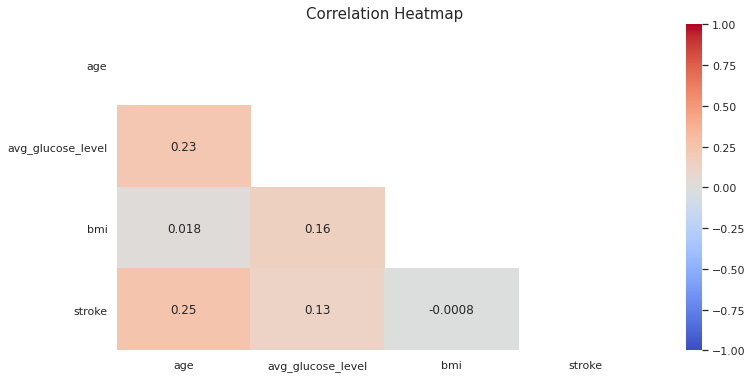

In [24]:
columns = numerical_columns + [target]
correlation_plot(df = df,
                 columns = columns)

Zbiór nie zawiera wysoce skorelowanych zmiennych ilościowych.

In [25]:
pd.DataFrame(df.isna().sum()).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,0,0,0,0,0,0,0,180,0,0


Zakładając, że pomiar glukozy
* Został wykonany na czco
* Jest podany w mg/dL

Jesteśmy w stanie wyróżnić (oczywiście wymagałoby to kontaktu ze specjalistą) cztery kategorie:
* avg_glucose_level < 70 - **zbyt niski poziom glukozy**
* 70 < avg_glucose_level < 88 - **prawodłowy poziom glukozy**
* 100 < avg_glucose_level < 125 - **stan przedcukrzycowy**
* 126 < avg_glucose_level - **cukrzyca**

Wartości BMI jesteśmy w stanie przyporządkować 8 kategorii (również wymagałoby to kontaktu ze specjalistą):
* BMI < 16 - **wygłodzenie**
* 16 < BMI < 16.99 - **wychudzenie**
* 17 < BMI < 18.49 - **niedowaga**
* 18.5 < BMI < 24.99 - **wartość prawidłowa**
* 25 < BMI < 29.99 - **nadwaga**
* 30 < BMI < 34.99 - **I stopen otylosci**
* 35 < BMI < 39.99 - **II stopien otylosci**
* 40 < BMI - **otyłość skrajna**


In [26]:
def glucose_level(glucose):
  if glucose <= 70:
    return "ZBYT_NISKI_POZIOM_GLUKOZY"
  elif glucose <= 99:
    return "PRAWIDLOWY_POZIOM_GLUKOZY"
  elif glucose <= 125:
    return "STAN_PRZEDCUKRZYCOWY"
  else:
    return "CUKRZYCA"

def bmi(bmi_level):
  if str(bmi_level) == "nan":
    return "BRAK"
  elif bmi_level < 16:
    return "WYGLODZENIE"
  elif bmi_level < 16.99:
    return "WYCHUDZENIE"
  elif bmi_level < 18.49:
    return "NIEDOWAGA"
  elif bmi_level < 24.99:
    return "WARTOSC_PRAWIDLOWA"
  elif bmi_level < 29.99:
    return "NADWAGA"
  elif bmi_level < 34.99:
    return " I_STOPIEN_OTYLOSCI"
  elif bmi_level < 39.99:
    return "II_STOPIEN_OTYLOSCI"
  else:
    return "OTYLOSC_SKRAJNA"

data = df.copy()
data["avg_glucose_level"] = data["avg_glucose_level"].apply(glucose_level)
data["bmi"] = data["bmi"].apply(bmi)

In [27]:
categorical_columns = ["gender",
                       "hypertension",
                       "heart_disease",
                       "ever_married",
                       "work_type",
                       "residence_type",
                       "smoking_status",
                       "avg_glucose_level",
                       "bmi"]

numerical_columns = ["age"]

target = "stroke"

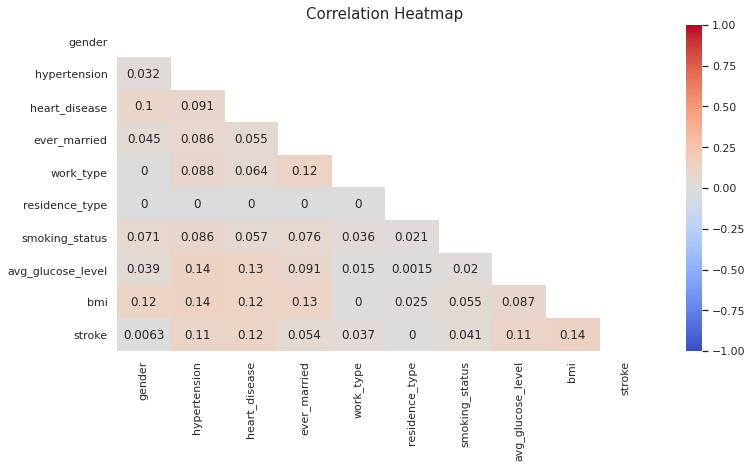

In [28]:
encoder = OrdinalEncoder()
columns = categorical_columns + [target]

data = pd.DataFrame(encoder.fit_transform(data[columns]), 
                    columns = columns)

correlation_plot(df = data,
                 columns = columns,
                 method = cramers_v)
del data

In [29]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class Transformer(BaseEstimator, TransformerMixin):
  def __bmi(self, value):
      if str(value) == "nan":
        return "BRAK"
      elif value < 16:
        return "WYGLODZENIE"
      elif value < 16.99:
        return "WYCHUDZENIE"
      elif value < 18.49:
        return "NIEDOWAGA"
      elif value < 24.99:
        return "WARTOSC_PRAWIDLOWA"
      elif value < 29.99:
        return "NADWAGA"
      elif value < 34.99:
        return " I_STOPIEN_OTYLOSCI"
      elif value < 39.99:
        return "II_STOPIEN_OTYLOSCI"
      else:
        return "OTYLOSC_SKRAJNA"
  
  def __glucose(self, value):
      if value <= 70:
        return "ZBYT_NISKI_POZIOM_GLUKOZY"
      elif value <= 99:
        return "PRAWIDLOWY_POZIOM_GLUKOZY"
      elif value <= 125:
        return "STAN_PRZEDCUKRZYCOWY"
      else:
        return "CUKRZYCA"

  def transform(self, X, y = None):
      X = X.copy()
      X["bmi"] = X["bmi"].apply(self.__bmi)
      X["avg_glucose_level"] = X["avg_glucose_level"].apply(self.__glucose)
      return X

  def fit(self, X, y = None):
    return self

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import WOEEncoder
from sklearn.compose import ColumnTransformer

X = df[categorical_columns + numerical_columns]
Y = df[target]

X_train, X_test, Y_train, Y_test =\
  train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 1)

In [ ]:
pipeline = Pipeline([("bmi_glucose", Transformer()),
                     ("woe", WOEEncoder(cols = categorical_columns))])

transformer = ColumnTransformer([("pipeline",
                                  pipeline,
                                  categorical_columns),
                                 ("scale",
                                  StandardScaler(),
                                  numerical_columns)])

X_train = pd.DataFrame(transformer.fit_transform(X_train, Y_train),
                       columns = X_train.columns,
                       index = X_train.index)
X_test = pd.DataFrame(transformer.transform(X_test),
                      columns = X_test.columns,
                      index = X_test.index)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(class_weight = "balanced")
lr.fit(X_train, Y_train)

print(classification_report(Y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       790
           1       0.16      0.82      0.27        49

    accuracy                           0.74       839
   macro avg       0.57      0.78      0.55       839
weighted avg       0.94      0.74      0.81       839



In [ ]:
import optuna 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

X_train_skf = X_train.values
Y_train_skf = Y_train.values

def objective(trial):
  param_grid = {
      "class_weight": "balanced",
      "random_state": 1,
      "solver": "liblinear",
      "C": trial.suggest_float("C", 0.01, 1),
      "penalty": trial.suggest_categorical("penalty", ["l1", "l2"])
  }
  
  skf = StratifiedKFold(n_splits = 3)
  test_scores = []

  for train_index, test_index in skf.split(X_train_skf, Y_train_skf):
    X_train_fold, X_test_fold = X_train_skf[train_index], X_train_skf[test_index]
    Y_train_fold, Y_test_fold = Y_train_skf[train_index], Y_train_skf[test_index]
  
    classifier = LogisticRegression(**param_grid)
    classifier.fit(X_train_fold, Y_train_fold)
    test_scores.append(roc_auc_score(Y_test_fold, classifier.predict(X_test_fold)))

  return np.asarray(test_scores).mean()


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 300)

In [34]:
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

param_grid = {
      "class_weight": ["balanced"],
      "random_state": [1],
      "solver": ["liblinear"],
      "C": [0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
      "penalty": ["l1", "l2"]
}

grid = GridSearchCV(estimator = LogisticRegression(),
                    param_grid = param_grid,
                    cv = StratifiedKFold(n_splits = 3), 
                    n_jobs = -1,
                    verbose = 10,
                    scoring = make_scorer(roc_auc_score))

grid.fit(X_train, Y_train)

In [36]:
lr = LogisticRegression(**grid.best_params_)
lr.fit(X_train, Y_train)

print(classification_report(Y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       790
           1       0.16      0.82      0.27        49

    accuracy                           0.74       839
   macro avg       0.57      0.78      0.55       839
weighted avg       0.94      0.74      0.81       839



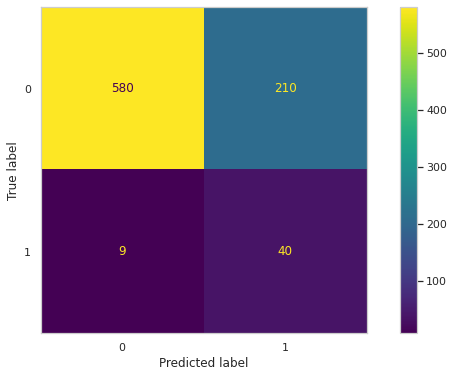

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize = (12, 6))
plot_confusion_matrix(lr, 
                      X_test, 
                      Y_test, 
                      ax = ax, 
                      values_format = '.0f')
plt.grid(False)
plt.show()

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(Y_test, lr.predict_proba(X_test)[:, 1])
data = list(zip(threshold, tpr, fpr))
trh = pd.DataFrame(data, 
                   columns = ["threshold", 
                              "true_positive_rate", 
                              "false_positive_rate"])
trh["tpr-fpr"] = trh["true_positive_rate"] - trh["false_positive_rate"]

In [39]:
trh.sort_values(by = "tpr-fpr", ascending = False).head(15)

,threshold,true_positive_rate,false_positive_rate,tpr-fpr
75,0.471639,0.877551,0.289873,0.587678
77,0.449149,0.897959,0.311392,0.586567
83,0.406173,0.938776,0.354430,0.584345
71,0.484098,0.857143,0.277215,0.579928
72,0.478753,0.857143,0.282278,0.574864
73,0.478572,0.857143,0.284810,0.572333
81,0.413386,0.918367,0.349367,0.569000
69,0.494920,0.836735,0.268354,0.568380
74,0.471847,0.857143,0.289873,0.567269
78,0.431520,0.897959,0.331646,0.566314


Według statystyki KS najlepszy cutoff równa się 0.47. Jego dobór oczywiscie powinien zależeć od celu jaki chcemy osiągnąc.

In [40]:
data = X_test.copy()
columns = data.columns
data["label"] = Y_test
data["pred_proba"] = lr.predict_proba(data[columns])[:, 1]

data = data.reset_index()

In [41]:
import shap

explainer = shap.Explainer(lr.predict_proba, data.loc[:, columns])
explainer_output = explainer(data.loc[:, columns])

expected_values = explainer_output.base_values[:1, :].reshape(-1)
shap_values = explainer_output.values

Exact explainer: 840it [00:24, 34.85it/s]                         


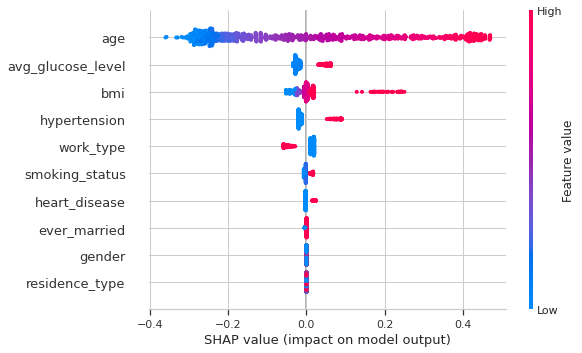

In [42]:
shap.summary_plot(shap_values[:, :, 1], data.loc[:, columns])

**Dlaczego model się myli?**

In [43]:
data.sort_values(by = "pred_proba").head(5)

,index,gender,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,avg_glucose_level,bmi,age,label,pred_proba
238,4613,-0.107172,-0.171323,-0.125646,-0.660372,-0.072563,0.045999,-0.147746,-0.283407,-0.391776,-1.826941,0,0.027354
274,2065,0.149624,-0.171323,-0.125646,-0.660372,-0.072563,0.045999,-0.147746,-0.283407,-0.391776,-1.826941,0,0.027354
709,4980,-0.107172,-0.171323,-0.125646,-0.660372,-0.072563,0.045999,-0.147746,-0.267214,-0.391776,-1.826941,0,0.027546
60,5083,-0.107172,-0.171323,-0.125646,-0.660372,-0.072563,0.045999,-0.064189,-0.283407,-0.391776,-1.826941,0,0.027867
695,4837,0.149624,-0.171323,-0.125646,-0.660372,-0.072563,-0.049453,-0.042801,-0.283407,-0.391776,-1.826941,0,0.027999


In [44]:
shap.initjs()
shap.force_plot(expected_values[1], shap_values[238].T[1], df.loc[4613, columns])

In [45]:
data.sort_values(by = "pred_proba", ascending=False).head(5)

,index,gender,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,avg_glucose_level,bmi,age,label,pred_proba
657,1813,-0.107172,0.822392,-0.125646,0.116256,-0.072563,-0.049453,-0.147746,-0.339580,1.661081,1.564319,0,0.949539
668,218,-0.107172,0.822392,1.060307,0.116256,0.281476,0.045999,-0.042801,0.703101,1.457482,1.449361,1,0.945545
456,867,-0.107172,-0.171323,1.060307,0.116256,-0.072563,-0.049453,-0.147746,0.703101,1.457482,1.506840,0,0.940858
761,171,-0.107172,0.822392,1.060307,-0.660372,0.281476,-0.049453,-0.147746,-0.339580,1.457482,1.621798,1,0.928576
64,126,0.149624,0.822392,-0.125646,0.116256,0.281476,0.045999,0.352438,-0.283407,1.457482,1.564319,1,0.926193


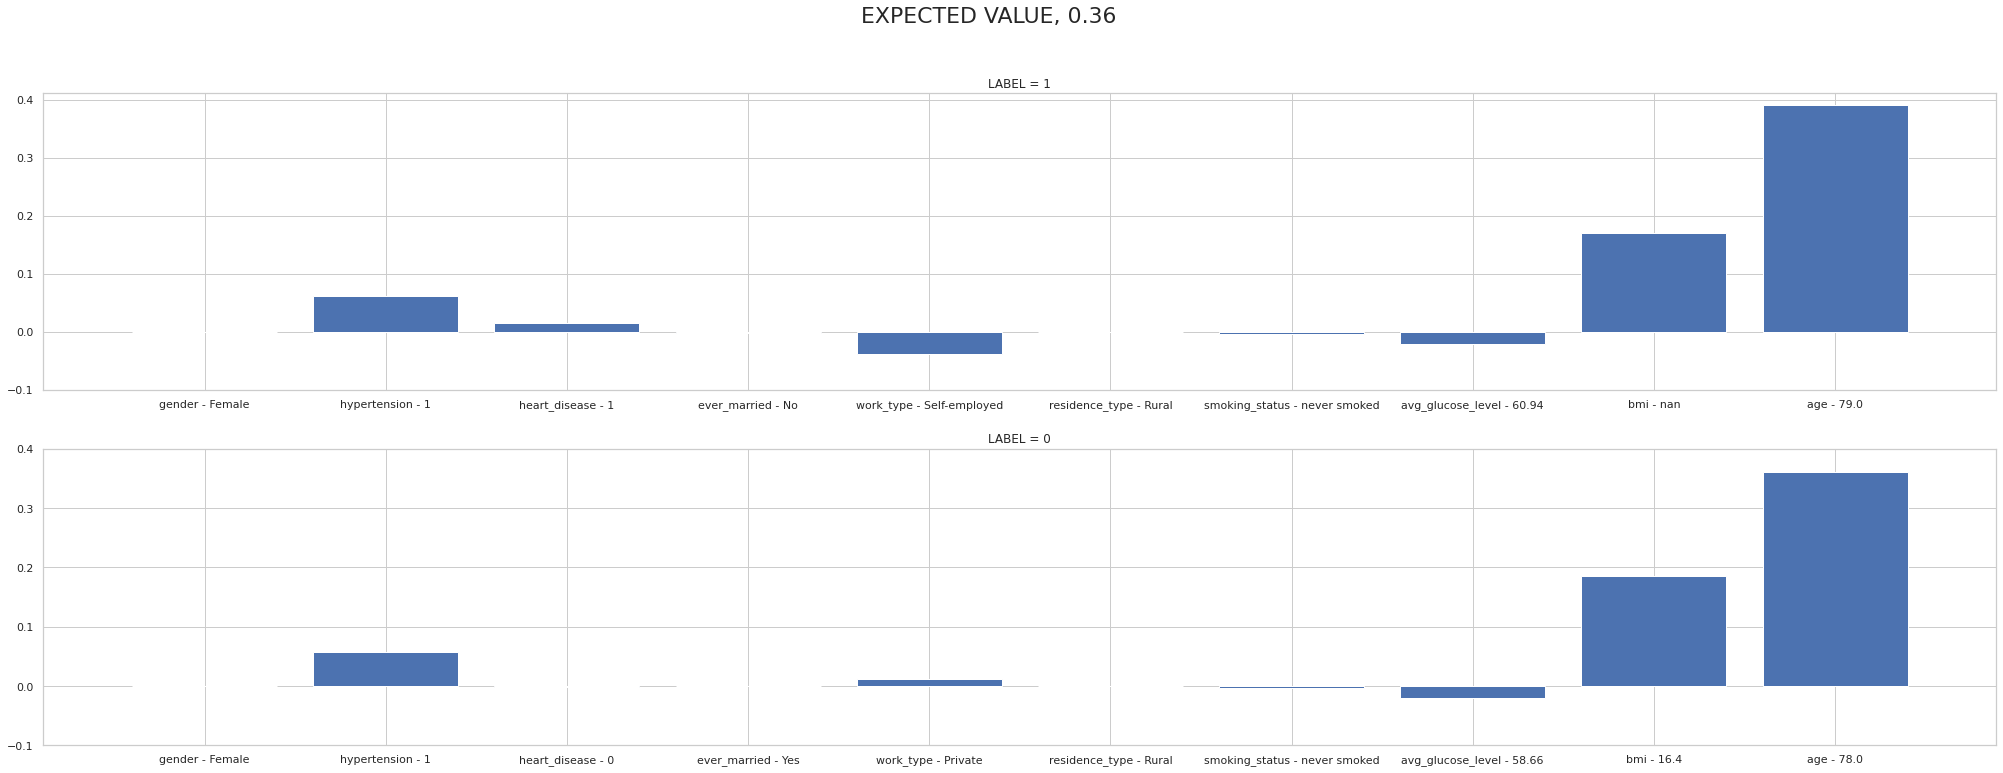

In [55]:
def column_values(columns, df, index):
  return [col + " - " + str(val) for col, val
          in zip(columns, df.loc[index, columns].values)]
          
fig, axes = plt.subplots(2, 1, figsize = (35, 12))
fig.suptitle("EXPECTED VALUE, {}".format(round(expected_values[1], 2)), fontsize = 22)
yticks = np.asarray(range(-1, 5)) / 10

axes[0].bar(column_values(columns, df, 171), 
            shap_values[761].T[1])
axes[0].set_title("LABEL = 1")
axes[0].set_yticks(yticks)

axes[1].bar(column_values(columns, df, 1813), 
            shap_values[657].T[1])
axes[1].set_title("LABEL = 0")
axes[1].set_yticks(yticks)

plt.show()

Zbiór zawiera część obserwacji, których zmienna celu określona jest na 0, a jednocześnie są one bardzo podobne do obserwacji określonych jako "sukces". Wiek okazał się najbardziej istotną cechą ze wszystkich dostepnych. Możliwe, że dodanie do zbioru innych cech, spowodowałoby korektę tej istotności oraz poprawę wyników.